<a href="https://colab.research.google.com/github/dlevonian/EmotionX-2019/blob/master/emotionx_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EmotionX 2019

[EmotionX 2019 Challenge](https://sites.google.com/view/emotionx2019/home?authuser=0)

Participants are challenged to predict the emotions induced by dialogue utterances by classifying each utterance into one of four label candidates: joy, sadness, anger, and neutral.

Leaderboard for the Friends dataset:

![alt text](https://drive.google.com/uc?id=1wWCGTD-rFySYK350_QQyEdXdDAzMKQ1d)

Thanks to David Patton for this great notebook:
https://github.com/dcpatton/NLP/blob/master/Friends_Albert.ipynb

Thanks to George Zoto, David Patton, and Robert Kraig for organizing the [Deep Learning Adventures](https://www.meetup.com/Deep-Learning-Adventures/) group

### Imports

In [ ]:
# make sure nightly builds are installed to use official.nlp modules
# this is needed for BERT tokenization and, optionally, for custom official.nlp optimizers
!pip install tf-nightly
!pip install -q tf-models-nightly

In [3]:
import numpy as np
import pandas as pd

import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
# %load_ext tensorboard

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.tokenization as tokenization
import official.nlp.optimization as optimization

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print('GPU is available' if tf.config.experimental.list_physical_devices('GPU') else 'CPU')

TF version:  2.4.0-dev20200811
Hub version:  0.8.0
GPU is available


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/EmotionX_2019/'

Mounted at /content/drive


In [6]:
seed_value= 2020
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Load EmotionX 2019

In [7]:
train_original = pd.read_json(path+'emotionx_data/2019_Train_Friends/Friends/friends.json')
print(train_original.shape)
train_original.head(2)

(1000, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Phoebe', 'utterance': 'Oh my God,...","{'speaker': 'Monica', 'utterance': 'What?', 'e...","{'speaker': 'Ross', 'utterance': 'Or! Or, we c...","{'speaker': 'Chandler', 'utterance': 'Youre a...","{'speaker': 'Joey', 'utterance': 'Aww, man, no...","{'speaker': 'Chandler', 'utterance': 'Now, the...","{'speaker': 'Phoebe', 'utterance': 'Hey.', 'em...","{'speaker': 'All', 'utterance': 'Hey!', 'emoti...","{'speaker': 'Phoebe', 'utterance': 'Ohh, you g...","{'speaker': 'Rachel', 'utterance': 'Where?!', ...","{'speaker': 'Phoebe', 'utterance': 'On the tou...","{'speaker': 'Ross', 'utterance': 'And', 'emoti...","{'speaker': 'Phoebe', 'utterance': 'No, I know...","{'speaker': 'Phoebe', 'utterance': 'I-Im sorr...","{'speaker': 'Monica', 'utterance': 'Well, next...","{'speaker': 'Joey', 'utterance': 'Yeah! Yeah! ...","{'speaker': 'Chandler', 'utterance': 'Thank yo...","{'speaker': 'Joey', 'utterance': 'No-no, thank...",None,None,None,None,None,None
1,"{'speaker': 'Joey', 'utterance': 'Hey Estelle,...","{'speaker': 'Estelle', 'utterance': 'Well! Wel...","{'speaker': 'Joey', 'utterance': 'What are you...","{'speaker': 'Estelle', 'utterance': 'Really?!'...","{'speaker': 'Joey', 'utterance': 'Yeah!', 'emo...","{'speaker': 'Estelle', 'utterance': 'Oh well, ...","{'speaker': 'Gary', 'utterance': 'Okay, you gu...","{'speaker': 'Ross', 'utterance': 'Yeah!!', 'em...","{'speaker': 'Chandler', 'utterance': 'Tonight?...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [8]:
# augmented data (round-trip translation)
train_augmented = pd.read_json(path+'emotionx_data/2019_Train_Friends/Friends/friends.augmented.json')
print(train_augmented.shape)
train_augmented.sample(2)

(1000, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
725,"{'speaker': 'Monica', 'utterance': 'Hey! What ...","{'speaker': 'Joey', 'utterance': 'I don't know...","{'speaker': 'Joey', 'utterance': 'It's not lik...","{'speaker': 'Joey', 'utterance': 'This is a se...","{'speaker': 'Joey', 'utterance': 'Y'know?', 'e...","{'speaker': 'Joey', 'utterance': 'And the nudi...","{'speaker': 'Monica', 'utterance': 'That's wha...","{'speaker': 'Joey', 'utterance': 'You're right...","{'speaker': 'Monica', 'utterance': 'No! No you...","{'speaker': 'Joey', 'utterance': 'Well that's ...","{'speaker': 'Joey', 'utterance': 'And I am onl...","{'speaker': 'Joey', 'utterance': 'Plus it soun...","{'speaker': 'Joey', 'utterance': 'My character...","{'speaker': 'Joey', 'utterance': 'Who run away...","{'speaker': 'Joey', 'utterance': 'So we go int...","{'speaker': 'Joey', 'utterance': 'It's really ...",None,None,None,None,None,None,None,None
986,"{'speaker': 'Chandler', 'utterance': 'How abou...","{'speaker': 'Joey', 'utterance': 'No, still to...","{'speaker': 'Chandler', 'utterance': 'Joey... ...","{'speaker': 'Joey', 'utterance': 'Plus, y'know...","{'speaker': 'Joey', 'utterance': 'Y'know, Joey...","{'speaker': 'Joey', 'utterance': 'Which I'm no...","{'speaker': 'Chandler', 'utterance': 'Joe...Jo...","{'speaker': 'Joey', 'utterance': 'Stalin...Sta...","{'speaker': 'Chandler', 'utterance': 'Well, it...","{'speaker': 'Joey', 'utterance': 'Joe Stalin. ...","{'speaker': 'Chandler', 'utterance': 'Might wa...","{'speaker': 'Joey', 'utterance': 'Joseph Stali...","{'speaker': 'Chandler', 'utterance': 'Oh yes! ...",None,None,None,None,None,None,None,None,None,None,None


In [9]:
# concatenate the regular and augmented
train_df = pd.concat([train_original, train_augmented], axis=0)
train_df.index = range(len(train_df))
train_df.shape

(2000, 24)

In [10]:
test_df = pd.read_json(path+'emotionx_data/2019_Eval_Labeled/friends_eval_gold.json')
print(test_df.shape)
test_df.sample(2)

(240, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
99,"{'speaker': 'Chandler', 'utterance': 'Did she ...","{'speaker': 'Phoebe', 'utterance': 'No, sorry....","{'speaker': 'Chandler', 'utterance': 'All righ...","{'speaker': 'Joey', 'utterance': 'No! Forget h...","{'speaker': 'Ross', 'utterance': 'Hes right, ...","{'speaker': 'Chandler', 'utterance': 'Well, ye...","{'speaker': 'Ross', 'utterance': 'How might yo...","{'speaker': 'Chandler', 'utterance': 'Well y'k...","{'speaker': 'Joey', 'utterance': 'Dude, tell m...","{'speaker': 'Chandler', 'utterance': 'She did ...","{'speaker': 'Ross', 'utterance': 'Thats all y...","{'speaker': 'Chandler', 'utterance': 'Thats n...","{'speaker': 'Joey', 'utterance': 'Whoa-whoa, t...","{'speaker': 'Chandler', 'utterance': 'Oh my Go...",None,None,None,None,None,None,None,None,None,None
26,"{'speaker': 'Joey', 'utterance': 'So thats wh...","{'speaker': 'Casting Director #2', 'utterance'...","{'speaker': 'Joey', 'utterance': 'Exactly.', '...","{'speaker': 'Casting Director #2', 'utterance'...","{'speaker': 'Joey', 'utterance': 'Or, I could ...","{'speaker': 'Casting Director #2', 'utterance'...","{'speaker': 'Joey', 'utterance': 'Yeah, okay.'...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [11]:
def flatten_dialogs(df):
    
    # u: single utterances
    # uu: if u is NOT the first utterance in the dialog, prepend the preceding utterance
    #     else, prepend "Start of the dialog:"
    
    speakers, u, uu, emotions  = [], [], [], []
    for r, row in df.iterrows():
        for i in range(len(df.columns)):
            if row[i] is not None:
                speakers.append(row[i]['speaker'])
                emotions.append(row[i]['emotion'])
                u.append(row[i]['utterance'].replace('\x92', '`'))
                if i==0:
                    uu.append(f'Start of the dialog: {u[-1]}')
                else:
                    uu.append(f'{u[-2]} {u[-1]}')
    return pd.DataFrame(zip(speakers, u, uu, emotions), columns =['speaker', 'u', 'uu', 'emotion'])    

In [12]:
train_df = flatten_dialogs(train_df)
train_df.head()

,speaker,u,uu,emotion
0,Phoebe,"Oh my God, he`s lost it. He`s totally lost it.","Start of the dialog: Oh my God, he`s lost it. ...",non-neutral
1,Monica,What?,"Oh my God, he`s lost it. He`s totally lost it....",surprise
2,Ross,"Or! Or, we could go to the bank, close our acc...","What? Or! Or, we could go to the bank, close o...",neutral
3,Chandler,You`re a genius!,"Or! Or, we could go to the bank, close our acc...",joy
4,Joey,"Aww, man, now we won`t be bank buddies!","You`re a genius! Aww, man, now we won`t be ban...",sadness


In [13]:
test_df = flatten_dialogs(test_df)
test_df.head()

,speaker,u,uu,emotion
0,Phoebe,"Alright, whadyou do with him?","Start of the dialog: Alright, whadyou do with ...",non-neutral
1,Monica,Oh! You're awake!,"Alright, whadyou do with him? Oh! You're awake!",surprise
2,Joey,Then you gotta come clean with Ma! This is not...,Oh! You're awake! Then you gotta come clean wi...,anger
3,Mr. Tribbiani,"Yeah, but this is",Then you gotta come clean with Ma! This is not...,neutral
4,Joey,I don't wanna hear it! Now go to my room!,"Yeah, but this is I don't wanna hear it! Now g...",anger


In [14]:
print(train_df.shape)
print(test_df.shape)

(29006, 4)
(3296, 4)


### Process train/test

In [15]:
# There are more speakers than the main 6 characters:
print(len(train_df.speaker.unique()))
train_df.speaker.unique()[:30]

309


array(['Phoebe', 'Monica', 'Ross', 'Chandler', 'Joey', 'All', 'Rachel',
       'Estelle', 'Gary', 'Guy', 'Woman', 'Mrs. Green', 'Dr. Harad',
       'Frank', 'Alice', 'Bob', 'Whitney', 'Kyle', 'Passerby', 'Susan',
       'Cookie', 'Kori', 'Dr. Long', 'Carol', 'Mark', 'TV Announcer',
       'The Hot Girl', 'Jen', 'Monica and Rachel', 'The Dry Cleaner'],
      dtype=object)

In [16]:
main_characters = train_df.speaker.value_counts()[:6].index.tolist()
print(main_characters)

['Ross', 'Joey', 'Rachel', 'Phoebe', 'Monica', 'Chandler']


In [17]:
# Label all non-main speakers as 'Other'
train_df.speaker = train_df.speaker.apply(lambda x: x if x in main_characters else 'Other')
test_df.speaker = test_df.speaker.apply(lambda x: x if x in main_characters else 'Other')

train_df.speaker.value_counts()

Other       4808
Ross        4332
Joey        4326
Rachel      4190
Phoebe      3852
Monica      3776
Chandler    3722
Name: speaker, dtype: int64

Explore the distribution of emotions:

In [18]:
speaker_emotions = train_df.groupby(['speaker', 'emotion']).count().reset_index()
speaker_emotions = speaker_emotions.pivot_table(index='speaker', columns='emotion', values='u', aggfunc=np.sum, margins=True)
speaker_emotions

emotion,anger,disgust,fear,joy,neutral,non-neutral,sadness,surprise,All
speaker,,,,,,,,,
Chandler,122,102,90,398,1742,772,92,404,3722
Joey,214,90,70,550,1960,816,120,506,4326
Monica,208,132,48,452,1568,790,96,482,3776
Other,246,70,78,572,2470,718,172,482,4808
Phoebe,228,94,60,464,1664,734,150,458,3852
Rachel,252,86,64,506,1644,872,198,568,4190
Ross,248,88,82,478,2012,842,168,414,4332
All,1518,662,492,3420,13060,5544,996,3314,29006


In [19]:
speaker_emotions = speaker_emotions.sort_values(by ='All', axis=1, ascending =False)
speaker_emotions = speaker_emotions.apply(lambda row: row/row[0], axis=1).drop('All', axis=1)
speaker_emotions

emotion,neutral,non-neutral,joy,surprise,anger,sadness,disgust,fear
speaker,,,,,,,,
Chandler,0.468028,0.207415,0.106932,0.108544,0.032778,0.024718,0.027405,0.024181
Joey,0.453074,0.188627,0.127138,0.116967,0.049468,0.027739,0.020804,0.016181
Monica,0.415254,0.209216,0.119703,0.127648,0.055085,0.025424,0.034958,0.012712
Other,0.513727,0.149334,0.118968,0.100250,0.051165,0.035774,0.014559,0.016223
Phoebe,0.431983,0.190550,0.120457,0.118899,0.059190,0.038941,0.024403,0.015576
Rachel,0.392363,0.208115,0.120764,0.135561,0.060143,0.047255,0.020525,0.015274
Ross,0.464451,0.194367,0.110342,0.095568,0.057248,0.038781,0.020314,0.018929
All,0.450252,0.191133,0.117907,0.114252,0.052334,0.034338,0.022823,0.016962


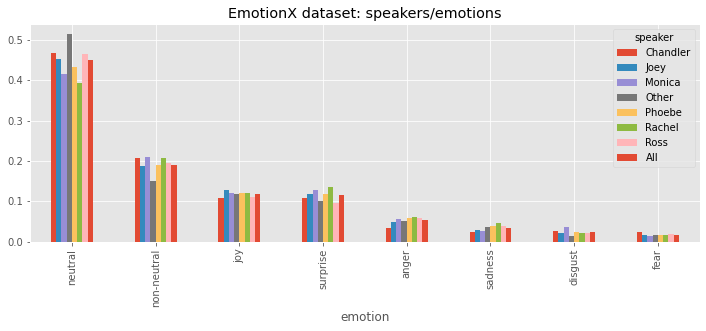

In [20]:
speaker_emotions.T.plot(kind='bar', figsize=(12, 4), title='EmotionX dataset: speakers/emotions');

#observation: emotions are relatively evenly spread among the speakers

In [21]:
# In EmotionX_2019, all 7 emotions are tagged but only 4 categories are counted towards the competition f1 metric:
# Neutral, Joy, Anger, Sadness
# 'Surprise', the second-largest distinct category, is not included (?)

allowed_emotions = ['neutral', 'joy', 'anger', 'sadness']
train_df = train_df[train_df.emotion.isin(allowed_emotions)]
test_df = test_df[test_df.emotion.isin(allowed_emotions)]

In [22]:
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['emotion'].values)
test_df['label']  = labelEncoder.transform(test_df['emotion'].values)
train_df.head()

,speaker,u,uu,emotion,label
2,Ross,"Or! Or, we could go to the bank, close our acc...","What? Or! Or, we could go to the bank, close o...",neutral,2
3,Chandler,You`re a genius!,"Or! Or, we could go to the bank, close our acc...",joy,1
4,Joey,"Aww, man, now we won`t be bank buddies!","You`re a genius! Aww, man, now we won`t be ban...",sadness,3
5,Chandler,"Now, there`s two reasons.","Aww, man, now we won`t be bank buddies! Now, t...",neutral,2
6,Phoebe,Hey.,"Now, there`s two reasons. Hey.",neutral,2


In [23]:
EMOTION_NAMES = labelEncoder.classes_
NUM_EMOTIONS = len(EMOTION_NAMES)
EMOTION_NAMES

array(['anger', 'joy', 'neutral', 'sadness'], dtype=object)

In [24]:
# encode the speakers
speakerEncoder = LabelEncoder()
train_df['s'] = speakerEncoder.fit_transform(train_df['speaker'].values)
test_df['s'] = speakerEncoder.transform(test_df['speaker'].values)
train_df.head()

,speaker,u,uu,emotion,label,s
2,Ross,"Or! Or, we could go to the bank, close our acc...","What? Or! Or, we could go to the bank, close o...",neutral,2,6
3,Chandler,You`re a genius!,"Or! Or, we could go to the bank, close our acc...",joy,1,0
4,Joey,"Aww, man, now we won`t be bank buddies!","You`re a genius! Aww, man, now we won`t be ban...",sadness,3,1
5,Chandler,"Now, there`s two reasons.","Aww, man, now we won`t be bank buddies! Now, t...",neutral,2,0
6,Phoebe,Hey.,"Now, there`s two reasons. Hey.",neutral,2,4


In [25]:
SPEAKER_NAMES = speakerEncoder.classes_
NUM_SPEAKERS = len(SPEAKER_NAMES)
SPEAKER_NAMES

array(['Chandler', 'Joey', 'Monica', 'Other', 'Phoebe', 'Rachel', 'Ross'],
      dtype=object)

In [54]:
# y_true to be used in performance metrics
y_true = test_df.label

# reindex
train_df.index = range(len(train_df))
test_df.index = range(len(test_df))
print(train_df.shape)
print(test_df.shape)

(18994, 6)
(1802, 6)


### Random f1

In [55]:
# scores_df to keep track of performace. Initialize with top-5 teams from EmotionX 2019 challenge
scores_df = pd.DataFrame(data={
                            'team/model': ['NTHU IDEA Lab --2019', 'KAKAO NLP+KU  --2019', 
                                           'HSU HK --2019', 'Alexandria U --2019', 'Antenna --2019'],
                            'micro-f1': [81.5, 79.5, 79.1, 77.0, 75.2],
                            'macro-f1': [73.1, 68.7, 69.9, 68.6, 63.8]
                            })

def update_scores(scores_df, model_name, y_pred, y_true=y_true, target_names=EMOTION_NAMES):

    report = classification_report(y_true, y_pred, target_names=target_names, digits=3)
    print(report)
    
    # f1 scores are contained at specific points in sklearn class.report string
    micro = 100*float(report.split('accuracy')[1][25:35])  
    macro = 100*float(report.split('macro avg')[1][25:35])
    scores_df.loc[scores_df.shape[0]]=[model_name, micro, macro]

    return scores_df

2 types of random benchmark:
- stratified, i.e. random shuffle preserving class weights
- majority class

In [56]:
# Stratified random shuffle
y_shuffled = y_true.copy().values
np.random.shuffle(y_shuffled)

scores_df = update_scores(scores_df, 'random stratified', y_shuffled)
scores_df.head(10)

              precision    recall  f1-score   support

       anger      0.106     0.106     0.106       141
         joy      0.307     0.307     0.307       505
     neutral      0.581     0.581     0.581      1035
     sadness      0.091     0.091     0.091       121

    accuracy                          0.434      1802
   macro avg      0.271     0.271     0.271      1802
weighted avg      0.434     0.434     0.434      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,Alexandria U --2019,77.0,68.6
4,Antenna --2019,75.2,63.8
5,random stratified,43.4,27.1


In [57]:
# predict all y_pred as majority class
maj_class = y_true.value_counts().index[0]
maj_pred = np.full_like(y_true, maj_class)
print(maj_class, EMOTION_NAMES[maj_class])

scores_df = update_scores(scores_df, 'all majority class', maj_pred)
scores_df.head(10)

2 neutral
              precision    recall  f1-score   support

       anger      0.000     0.000     0.000       141
         joy      0.000     0.000     0.000       505
     neutral      0.574     1.000     0.730      1035
     sadness      0.000     0.000     0.000       121

    accuracy                          0.574      1802
   macro avg      0.144     0.250     0.182      1802
weighted avg      0.330     0.574     0.419      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,Alexandria U --2019,77.0,68.6
4,Antenna --2019,75.2,63.8
5,random stratified,43.4,27.1
6,all majority class,57.4,18.2


### Load BERT, encode

In [58]:
tic = time.time()
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",  
                            name = 'bert_layer',
                            trainable=True)
toc = time.time()
print(f'done in {toc-tic:.1f} sec')

done in 6.2 sec


In [59]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
# dir(tokenizer)

In [60]:
tokens = tokenizer.tokenize(train_df.u[0])
ids = tokenizer.convert_tokens_to_ids(tokens)

print(tokens)
print(ids)

['or', '!', 'or', ',', 'we', 'could', 'go', 'to', 'the', 'bank', ',', 'close', 'our', 'accounts', 'and', 'cut', 'them', 'off', 'at', 'the', 'source', '.']
[2030, 999, 2030, 1010, 2057, 2071, 2175, 2000, 1996, 2924, 1010, 2485, 2256, 6115, 1998, 3013, 2068, 2125, 2012, 1996, 3120, 1012]


In [61]:
def encode_sentence(s):
    # any input sequence in BERT must start with [CLS] token
    # the first sentence (whether in pairs or standalone) must end with [SEP]
    return (tokenizer.convert_tokens_to_ids(['[CLS]']) + 
            tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s)) + 
            tokenizer.convert_tokens_to_ids(['[SEP]']))

train_ids = train_df.u.apply(encode_sentence)
test_ids = test_df.u.apply(encode_sentence)

In [62]:
max_len_train = max(map(len, train_ids))
max_len_test = max(map(len, test_ids))
MAX_LEN = max(max_len_train, max_len_test)

print(f'max len train =', max_len_train)
print(f'max len test =', max_len_test)
print(f'MAX LEN =', MAX_LEN)

max len train = 65
max len test = 67
MAX LEN = 67


### TF Dataset

In [63]:
train_df.sample(5)

,speaker,u,uu,emotion,label,s
15818,Phoebe,Hey Mikey,Start of the dialog: Hey Mikey,neutral,2,4
8830,Other,"Flowers of Evil, by Beaudalire. Have you read it?","Oh yeah, what are you reading? Flowers of Evil...",neutral,2,3
16198,Phoebe,"Doogie, shh!","Shh! Doogie, shh!",anger,0,4
7058,Rachel,"Hello? Yes, she is, hold on a second, please. ...","I'm- I'm Monana! Hello? Yes, she is, hold on a...",neutral,2,5
4551,Joey,Fine!,I don`t have time to convince you because he`s...,anger,0,1


In [64]:
BATCH_SIZE=32

def bert_dataset(df, 
                 max_len=MAX_LEN, 
                 batch_size=BATCH_SIZE, 
                 num_emotions=NUM_EMOTIONS,
                 include_speakers=False,
                 num_speakers=NUM_SPEAKERS,
                 add_preceding=False,
                 train_size=0.9,
                 shuffle=True,
                 ):
    """
    Produce TF datasets, both train and val, from the input dataframe
    The convention for the input df: 
        labels       in column 'label,
        utterances   in column 'u'
        double utts  in column 'uu'
        speakers     in column 's'
    """
    input_word_ids=[]

    if not add_preceding:
        for sentence in df['u']:
            input_word_ids.append(encode_sentence(sentence))
    else:
        for sentence in df['uu']:
            input_word_ids.append(encode_sentence(sentence))

    input_word_ids = pad_sequences(input_word_ids, maxlen=max_len, dtype="long", value=0, padding="post")
    input_mask = np.vectorize(lambda arr: int(arr>0))(input_word_ids)
    # BERT needs the 'segment ids' element. For single-sentence tasks such as classification, supply zeros
    input_segment_ids = np.zeros_like(input_mask)
    
    if not include_speakers:
        inputs = (input_word_ids, input_mask, input_segment_ids)
    else:
        speakers = to_categorical(df['s'].values, num_classes=num_speakers)
        inputs = (input_word_ids, input_mask, input_segment_ids, speakers)
    
        # one-hot encode the labels
    labels = to_categorical(df['label'].values, num_classes=num_emotions)

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    if shuffle: dataset = dataset.shuffle(1024)
    
    train_size = int(train_size*df.shape[0])
    train_ds = dataset.take(train_size).batch(batch_size).cache()
    val_ds   = dataset.skip(train_size).batch(batch_size).cache()
    
    return train_ds, val_ds


In [65]:
train_ds, val_ds = bert_dataset(train_df)
# train_ds, val_ds = bert_dataset(train_df, include_speakers=True)

# inspect the dataset element
print(train_ds.element_spec )
next(iter(train_ds))


((TensorSpec(shape=(None, 67), dtype=tf.int64, name=None), TensorSpec(shape=(None, 67), dtype=tf.int64, name=None), TensorSpec(shape=(None, 67), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))


((<tf.Tensor: shape=(32, 67), dtype=int64, numpy=
  array([[ 101, 4931,  999, ...,    0,    0,    0],
         [ 101, 2138, 1997, ...,    0,    0,    0],
         [ 101, 2122, 1011, ...,    0,    0,    0],
         ...,
         [ 101, 2428, 1029, ...,    0,    0,    0],
         [ 101, 2348, 1010, ...,    0,    0,    0],
         [ 101, 1045, 2097, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(32, 67), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(32, 67), dtype=int64, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(32, 4), dtype=float32, numpy=
 array([[0., 1., 0., 0.],
  

### BERT model

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.initializers import Constant

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

from tensorflow.keras import callbacks
import tensorflow.keras.backend as K


In [67]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(NUM_EMOTIONS, average='micro', name='f1')   # the competition metric

In [68]:

def bert_model( max_len=MAX_LEN, 
                num_emotions=NUM_EMOTIONS,
                include_speakers=False,
                num_speakers=NUM_SPEAKERS,
                dropout_rate=0.1, 
                seed=seed_value):
 
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask     = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids    = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    speakers = Input(shape=(num_speakers,), dtype=tf.float32, name="speakers")

    # deep copy of a keras layer object is problematic, therefore download for each instance
    bert = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",  
                                name = 'bert_layer', trainable=True)

    if not include_speakers:
        inputs = [input_word_ids, input_mask, segment_ids]
        x, _ = bert(inputs)
        x = Dropout(dropout_rate, seed=seed, name='dropout')(x)
    else:
        inputs = [input_word_ids, input_mask, segment_ids, speakers]
        x, _ = bert(inputs[:-1])
        x = Dropout(dropout_rate, seed=seed, name='dropout')(x)
        x = tf.concat([x, speakers], axis=1)
        x = Dense(512, activation='relu')(x)

    output = Dense(num_emotions, activation='softmax')(x)
    model = Model(inputs, output)

    return model


In [69]:
def plot_training(history):

    f,axes = plt.subplots(1, 2, figsize=(12, 4))
    ax0,ax1=axes[0],axes[1]
    
    hist = history.history
    epochs = np.arange(1,1+len(hist['loss']))

    ax0.plot(epochs, hist['f1'], label='f1 train') 
    ax0.plot(epochs, hist['val_f1'], label='f1 val') 
    ax0.set_title('f1 score')
    ax0.legend()

    ax1.plot(epochs, hist['P'], label='precision train') 
    ax1.plot(epochs, hist['R'], label='recall train') 
    ax1.plot(epochs, hist['val_P'], label='precision val') 
    ax1.plot(epochs, hist['val_R'], label='recall val') 
    ax1.set_title('precision / recall')
    ax1.legend()

    plt.show()

In [70]:
# test model
model = bert_model()
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 67)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 67)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 67)]         0                                            
__________________________________________________________________________________________________
bert_layer (KerasLayer)         [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [71]:
# Test the computational graph
tic=time.time()
sample_input = next(iter(train_ds))

# Dataset is a generator of (X,Y). Only X should be passed to the model, i.e. sample_input[0]
sample_output = model(sample_input[0])

toc=time.time()
print(f'done in {toc-tic:.1f} sec')
print(sample_output.shape)


done in 0.5 sec
(32, 4)


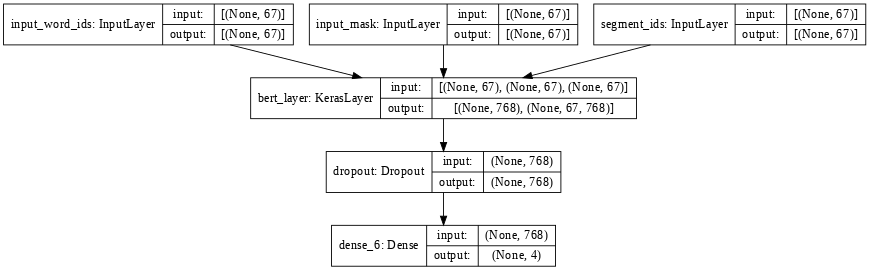

In [72]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

Common callbacks to be used in all models

In [73]:
def scheduler(epoch, lr):
    # keep the original lr for flat_period epochs, exponential decay since then subject to floor_lr
    flat_period, decay, floor_lr = 1, -0.2, 1e-6
    if epoch<=flat_period: return lr
    return max(lr*np.exp(decay), floor_lr)
   
lr_callback = callbacks.LearningRateScheduler(scheduler, verbose=1) 

es_callback = callbacks.EarlyStopping(monitor='val_f1', verbose=1, patience=2, mode='max')


### m0. single utt

In [74]:
train_ds, val_ds = bert_dataset(train_df)
test_ds = bert_dataset(test_df, train_size=1, shuffle=False)[0]

EPOCHS = 10

model_0 = bert_model(dropout_rate=0)

model_0.compile(optimizer=Adam(1e-5),
                loss=CategoricalCrossentropy(),
                metrics=[f1_score, Precision(name='P'), Recall(name='R')])

history = model_0.fit(
                train_ds,
                epochs=EPOCHS,
                verbose=1,
                callbacks = [lr_callback, es_callback],
                validation_data=val_ds)



Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/10
535/535 [==============================] - 160s 299ms/step - loss: 0.6999 - f1: 0.7438 - P: 0.8044 - R: 0.6886 - val_loss: 0.3975 - val_f1: 0.8589 - val_P: 0.8747 - val_R: 0.8411

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/10
535/535 [==============================] - 145s 271ms/step - loss: 0.3823 - f1: 0.8705 - P: 0.8850 - R: 0.8546 - val_loss: 0.2973 - val_f1: 0.8984 - val_P: 0.9084 - val_R: 0.8874

Epoch 00003: LearningRateScheduler reducing learning rate to 8.187307323951033e-06.
Epoch 3/10
535/535 [==============================] - 145s 271ms/step - loss: 0.2460 - f1: 0.9226 - P: 0.9296 - R: 0.9141 - val_loss: 0.1903 - val_f1: 0.9368 - val_P: 0.9397 - val_R: 0.9342

Epoch 00004: LearningRateScheduler reducing learning rate to 6.703200586742346e-06.
Epoch 4/10
535/535 [==============================] - 145s 271ms/step - loss: 0.1562 - f1:

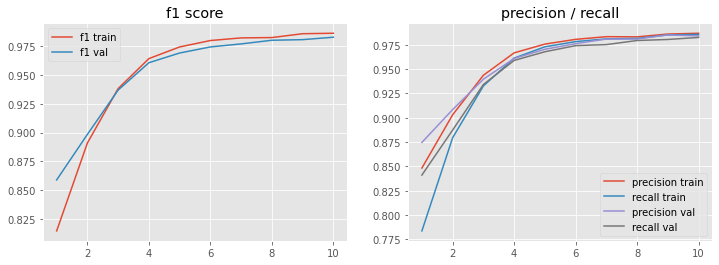

In [75]:
plot_training(history)

In [76]:
y_pred = model_0.predict(test_ds).argmax(axis=1)

scores_df = update_scores(scores_df, 'model 0. single utterance', y_pred)
scores_df.head(10)

              precision    recall  f1-score   support

       anger      0.688     0.624     0.654       141
         joy      0.826     0.659     0.733       505
     neutral      0.811     0.918     0.861      1035
     sadness      0.630     0.521     0.570       121

    accuracy                          0.796      1802
   macro avg      0.739     0.681     0.705      1802
weighted avg      0.794     0.796     0.790      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,Alexandria U --2019,77.0,68.6
4,Antenna --2019,75.2,63.8
5,random stratified,43.4,27.1
6,all majority class,57.4,18.2
7,model 0. single utterance,79.6,70.5


### m1. +speakers ids

In [77]:
train_ds, val_ds = bert_dataset(train_df, include_speakers=True)
test_ds = bert_dataset(test_df, include_speakers=True, train_size=1, shuffle=False)[0]

EPOCHS = 10

model_1 = bert_model(include_speakers=True, dropout_rate=0)

model_1.compile(optimizer=Adam(1e-5),
                loss=CategoricalCrossentropy(),
                metrics=[f1_score, Precision(name='P'), Recall(name='R')])

history = model_1.fit(
                train_ds,
                epochs=EPOCHS,
                verbose=1,
                callbacks = [lr_callback, es_callback],
                validation_data=val_ds)



Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/10
535/535 [==============================] - 162s 303ms/step - loss: 0.6853 - f1: 0.8324 - P: 0.8006 - R: 0.7187 - val_loss: 0.3953 - val_f1: 0.8663 - val_P: 0.8814 - val_R: 0.8484

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/10
535/535 [==============================] - 145s 271ms/step - loss: 0.3913 - f1: 0.8693 - P: 0.8858 - R: 0.8517 - val_loss: 0.2885 - val_f1: 0.9021 - val_P: 0.9056 - val_R: 0.8984

Epoch 00003: LearningRateScheduler reducing learning rate to 8.187307323951033e-06.
Epoch 3/10
535/535 [==============================] - 145s 271ms/step - loss: 0.2499 - f1: 0.9203 - P: 0.9280 - R: 0.9125 - val_loss: 0.1850 - val_f1: 0.9395 - val_P: 0.9428 - val_R: 0.9374

Epoch 00004: LearningRateScheduler reducing learning rate to 6.703200586742346e-06.
Epoch 4/10
535/535 [==============================] - 145s 271ms/step - loss: 0.1590 - f1:

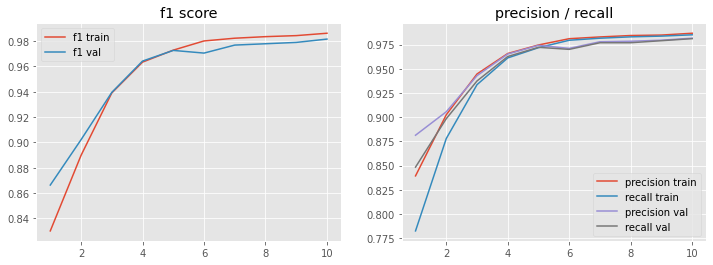

In [78]:
plot_training(history)

In [79]:
y_pred = model_1.predict(test_ds).argmax(axis=1)

scores_df = update_scores(scores_df, 'model 1. +speaker ids', y_pred)
scores_df.head(10)


              precision    recall  f1-score   support

       anger      0.695     0.631     0.662       141
         joy      0.826     0.659     0.733       505
     neutral      0.816     0.923     0.866      1035
     sadness      0.634     0.529     0.577       121

    accuracy                          0.800      1802
   macro avg      0.743     0.686     0.709      1802
weighted avg      0.797     0.800     0.794      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,Alexandria U --2019,77.0,68.6
4,Antenna --2019,75.2,63.8
5,random stratified,43.4,27.1
6,all majority class,57.4,18.2
7,model 0. single utterance,79.6,70.5
8,model 1. +speaker ids,80.0,70.9


### m2. +preceding utt

In [80]:
train_ds, val_ds = bert_dataset(train_df, include_speakers=True, add_preceding=True, max_len=2*MAX_LEN)
test_ds = bert_dataset(test_df, include_speakers=True, add_preceding=True, max_len=2*MAX_LEN, train_size=1, shuffle=False)[0]

EPOCHS = 10

model_2 = bert_model(include_speakers=True, max_len=2*MAX_LEN, dropout_rate=0)

model_2.compile(optimizer=Adam(1e-5),
              loss=CategoricalCrossentropy(),
              metrics=[f1_score, Precision(name='P'), Recall(name='R')])

history = model_2.fit(
                train_ds,
                epochs=EPOCHS,
                verbose=1,
                callbacks = [lr_callback, es_callback],
                validation_data=val_ds)



Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/10
535/535 [==============================] - 293s 547ms/step - loss: 0.7096 - f1: 0.8160 - P: 0.7859 - R: 0.6796 - val_loss: 0.3705 - val_f1: 0.8679 - val_P: 0.8837 - val_R: 0.8558

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/10
535/535 [==============================] - 277s 518ms/step - loss: 0.3614 - f1: 0.8743 - P: 0.8870 - R: 0.8605 - val_loss: 0.2350 - val_f1: 0.9184 - val_P: 0.9240 - val_R: 0.9147

Epoch 00003: LearningRateScheduler reducing learning rate to 8.187307323951033e-06.
Epoch 3/10
535/535 [==============================] - 277s 518ms/step - loss: 0.1979 - f1: 0.9339 - P: 0.9393 - R: 0.9304 - val_loss: 0.1285 - val_f1: 0.9626 - val_P: 0.9641 - val_R: 0.9621

Epoch 00004: LearningRateScheduler reducing learning rate to 6.703200586742346e-06.
Epoch 4/10
535/535 [==============================] - 277s 518ms/step - loss: 0.1105 - f1:

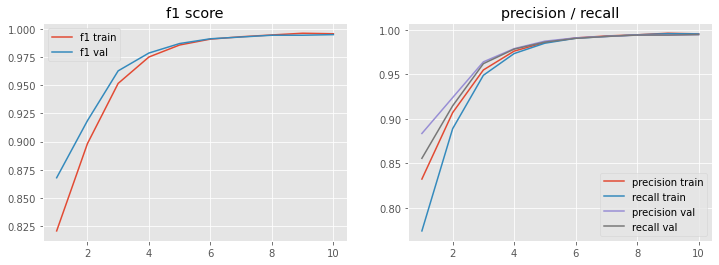

In [81]:
plot_training(history)

In [82]:
y_pred = model_2.predict(test_ds).argmax(axis=1)

scores_df = update_scores(scores_df, 'model 2. +preceding utternace', y_pred)
scores_df.head(10)

              precision    recall  f1-score   support

       anger      0.721     0.567     0.635       141
         joy      0.816     0.614     0.701       505
     neutral      0.790     0.926     0.852      1035
     sadness      0.684     0.554     0.612       121

    accuracy                          0.785      1802
   macro avg      0.752     0.665     0.700      1802
weighted avg      0.785     0.785     0.777      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,Alexandria U --2019,77.0,68.6
4,Antenna --2019,75.2,63.8
5,random stratified,43.4,27.1
6,all majority class,57.4,18.2
7,model 0. single utterance,79.6,70.5
8,model 1. +speaker ids,80.0,70.9
9,model 2. +preceding utternace,78.5,70.0


### Scores

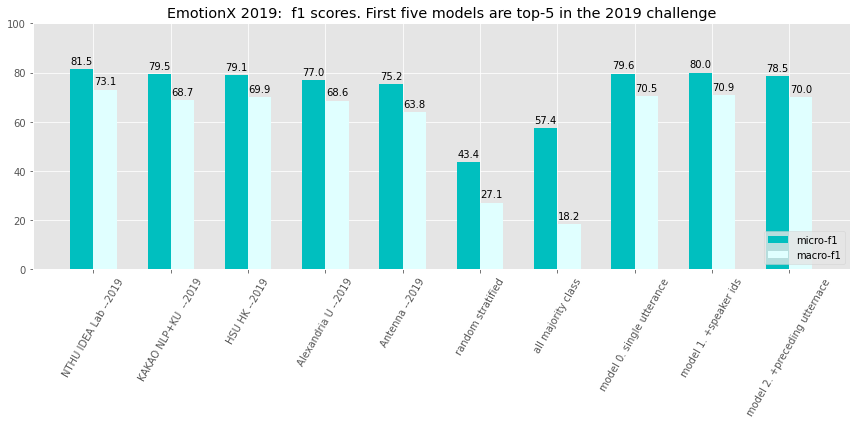

In [113]:
x = np.arange(len(scores_df))
width = 0.3

fig, ax = plt.subplots(figsize=(12, 6))
micro = ax.bar(x-width/2, scores_df['micro-f1'], width, label='micro-f1', color='c')
macro = ax.bar(x+width/2, scores_df['macro-f1'], width, label='macro-f1', color='lightcyan')

ax.set_title('EmotionX 2019:  f1 scores. First five models are top-5 in the 2019 challenge')
ax.set_ylim(0,100)
ax.set_xticks(x)
ax.set_xticklabels(scores_df['team/model'], rotation=60)
ax.legend(loc='lower right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}', xy=(rect.get_x()+.5*rect.get_width(), height), xytext=(0,3), 
                                     textcoords="offset points", ha='center', va='bottom')
autolabel(micro)
autolabel(macro)
fig.tight_layout()
plt.show()

### Extract BERT features

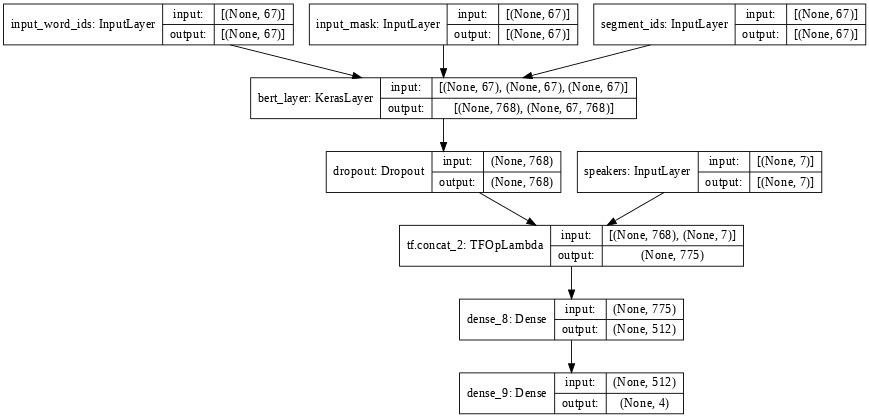

In [88]:
# extract the pre-trained BERT sentence embeddings from the best-performing model
# model_1 includes the speaker one-hot vector after concatenation
tf.keras.utils.plot_model(model_1, show_shapes=True, dpi=64)

In [92]:
model_1.layers[6]

In [93]:
# output at layer 4 after dropout
bert_extractor = keras.Model(inputs=model_1.input, outputs=model_1.layers[6].output)

# datasets w/o shuffling. order must be preserved for feature extraction, to be aligned with the labels
f_train_ds = bert_dataset(train_df, include_speakers=True, train_size=1, shuffle=False)[0]
f_test_ds  = bert_dataset(test_df,  include_speakers=True, train_size=1, shuffle=False)[0]

# produce numpy features
f_train = bert_extractor.predict(f_train_ds)
f_test  = bert_extractor.predict(f_test_ds)

print(train_df.shape, f_train.shape)
print(test_df.shape, f_test.shape)

# save numpy features 
np.save(path+'models/train_extracted_m1', f_train, allow_pickle=True)
np.save(path+'models/test_extracted_m1', f_test, allow_pickle=True)

(18994, 6) (18994, 775)
(1802, 6) (1802, 775)
